In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import pytorch_models
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


In [3]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [4]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)



torch.Size([20, 10])
('tom_low', 1) tensor(1) 44100


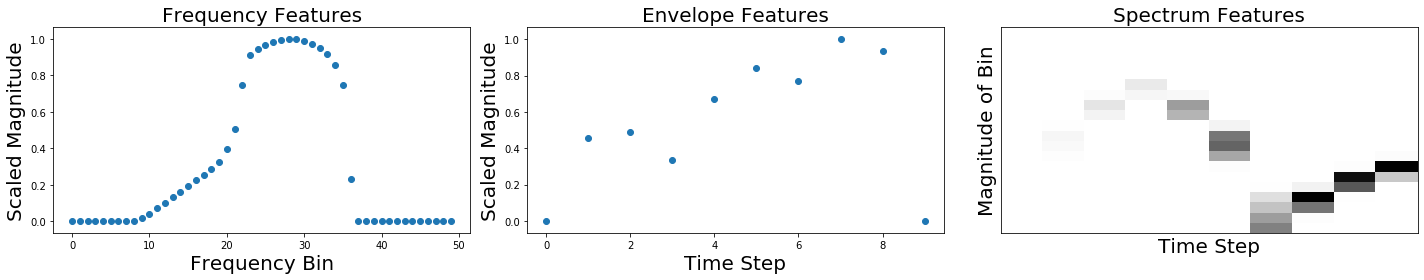

In [5]:
FREQ_BINS=20
TIME_STEPS=10
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,)
        sf=ft.detach().numpy()
        ft=ft.detach().numpy()
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER WITH CNN

In [35]:
FREQ_BINS = 30
TIME_STEPS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.50,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)

train_synthless=train[train["label_num"]==0]
test_synthless=test[test["label_num"]==0]
class AE_Conv(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate=0.5,num_channels=5):
        super(AE_Conv, self).__init__()
        self.W=input_shape[0]
        self.H=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=num_channels, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//2 * self.W//2) * 8, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m

In [30]:
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 64
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06


spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

#make dataloader 
ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
spec_data_test_nosynth = audioDataset(test_synthless,".",task="dvn", transform=ptTune)
spec_test_nosynth_loader= DataLoader(spec_data_test_nosynth, batch_size=16,shuffle=True, num_workers=8)

model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5).to(device)
# model = model_loader(model,"models/encode/nosynth_64_40_0.000577.pt")
#train


optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
df=pd.DataFrame(columns=["epoch","train_loss","test_loss"])

# mean-squared error loss
criterion = nn.MSELoss()
epochs=200
for epoch in range(epochs):
    loss = 0
    for batch_features in spec_train_nosynth_loader:
        batch_features=batch_features["feats"]
        batch_features = batch_features.view(-1, spec_dimension).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(spec_train_nosynth_loader)
    test_loss=0
    with torch.no_grad():
        for batch_features in spec_test_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            outputs = model(batch_features)
            temp_loss = criterion(outputs, batch_features)
            test_loss += temp_loss.item()
    test_loss = test_loss / len(spec_test_nosynth_loader) 
  
    df.loc[len(df)]=[epoch,loss,test_loss]
    df.to_csv("./csvs/cnn_64_trainingv2.csv")
    print("epoch : {}/{}, loss = {:.6f}, test_loss = {:.6f}".format(epoch, epochs, loss,test_loss))
    if epoch%5==0:
        print("saving")
        torch.save(model.state_dict(),'./models/encode/nosynth_%d_%d_%f.pt'%(latent_size ,epoch,loss,))
    



epoch : 0/200, loss = 0.003769, test_loss = 0.002545
saving
epoch : 1/200, loss = 0.001914, test_loss = 0.001670
epoch : 2/200, loss = 0.001450, test_loss = 0.001331
epoch : 3/200, loss = 0.001303, test_loss = 0.001200
epoch : 4/200, loss = 0.001201, test_loss = 0.001145
epoch : 5/200, loss = 0.001106, test_loss = 0.001107
saving
epoch : 6/200, loss = 0.001056, test_loss = 0.001054
epoch : 7/200, loss = 0.000999, test_loss = 0.001007
epoch : 8/200, loss = 0.000970, test_loss = 0.001060
epoch : 9/200, loss = 0.000952, test_loss = 0.000949
epoch : 10/200, loss = 0.000928, test_loss = 0.000947
saving
epoch : 11/200, loss = 0.000914, test_loss = 0.000946
epoch : 12/200, loss = 0.000876, test_loss = 0.000917
epoch : 13/200, loss = 0.000855, test_loss = 0.000893
epoch : 14/200, loss = 0.000830, test_loss = 0.000883
epoch : 15/200, loss = 0.000820, test_loss = 0.000851
saving
epoch : 16/200, loss = 0.000802, test_loss = 0.000843
epoch : 17/200, loss = 0.000799, test_loss = 0.000875
epoch : 18

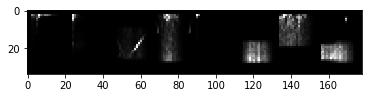

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


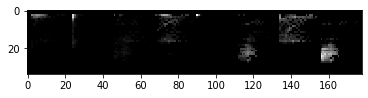

tensor([0, 0, 1, 1, 0, 1, 1, 1])

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#extracting features and putting them into the csv folder for plotting
compression_dim=64

spec_dimension=FREQ_BINS*TIME_STEPS
m=model
dataiter=iter(spec_test_loader)
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:8].reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
# images=torch.transpose(images,2,3)
y=xy["label"].detach()[0:8]
imshow(tv.utils.make_grid(images))

batch_features=xy["feats"][0:8].to(device)
# batch_features=torch.transpose(batch_features,1,2)
recon=m(batch_features)
recon=recon.reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
imshow(tv.utils.make_grid(recon))

y

In [112]:
from PIL import Image
from transforms import RGBTransform # from source code mentioned above

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = tv.utils.make_grid(images).numpy()   
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

ModuleNotFoundError: No module named 'transforms'

In [107]:
t=images.numpy()


(30, 20)
(30, 20)
(30, 20)
(30, 20)
(30, 20)
(30, 20)
(30, 20)
(30, 20)


In [114]:
#by william chargin
"""A library for describing and applying affine transforms to PIL images."""
import numpy as np
import PIL.Image


class RGBTransform(object):
    """A description of an affine transformation to an RGB image.
    This class is immutable.
    Methods correspond to matrix left-multiplication/post-application:
    for example,
        RGBTransform().multiply_with(some_color).desaturate()
    describes a transformation where the multiplication takes place first.
    Use rgbt.applied_to(image) to return a converted copy of the given image.
    For example:
        grayish = RGBTransform.desaturate(factor=0.5).applied_to(some_image)
    """

    def __init__(self, matrix=None):
        self._matrix = matrix if matrix is not None else np.eye(4)

    def _then(self, operation):
        return RGBTransform(np.dot(_embed44(operation), self._matrix))

    def desaturate(self, factor=1.0, weights=(0.299, 0.587, 0.114)):
        """Desaturate an image by the given amount.
        A factor of 1.0 will make the image completely gray;
        a factor of 0.0 will leave the image unchanged.
        The weights represent the relative contributions of each channel.
        They should be a 1-by-3 array-like object (tuple, list, np.array).
        In most cases, their values should sum to 1.0
        (otherwise, the transformation will cause the image
        to get lighter or darker).
        """
        weights = _to_rgb(weights, "weights")

        # tile: [wr, wg, wb]  ==>  [[wr, wg, wb], [wr, wg, wb], [wr, wg, wb]]
        desaturated_component = factor * np.tile(weights, (3, 1))
        saturated_component = (1 - factor) * np.eye(3)
        operation = desaturated_component + saturated_component

        return self._then(operation)

    def multiply_with(self, base_color, factor=1.0):
        """Multiply an image by a constant base color.
        The base color should be a 1-by-3 array-like object
        representing an RGB color in [0, 255]^3 space.
        For example, to multiply with orange,
        the transformation
            RGBTransform().multiply_with((255, 127, 0))
        might be used.
        The factor controls the strength of the multiplication.
        A factor of 1.0 represents straight multiplication;
        other values will be linearly interpolated between
        the identity (0.0) and the straight multiplication (1.0).
        """
        component_vector = _to_rgb(base_color, "base_color") / 255.0
        new_component = factor * np.diag(component_vector)
        old_component = (1 - factor) * np.eye(3)
        operation = new_component + old_component

        return self._then(operation)

    def mix_with(self, base_color, factor=1.0):
        """Mix an image by a constant base color.
        The base color should be a 1-by-3 array-like object
        representing an RGB color in [0, 255]^3 space.
        For example, to mix with orange,
        the transformation
            RGBTransform().mix_with((255, 127, 0))
        might be used.
        The factor controls the strength of the color to be added.
        If the factor is 1.0, all pixels will be exactly the new color;
        if it is 0.0, the pixels will be unchanged.
        """
        base_color = _to_rgb(base_color, "base_color")
        operation = _embed44((1 - factor) * np.eye(3))
        operation[:3, 3] = factor * base_color

        return self._then(operation)

    def get_matrix(self):
        """Get the underlying 3-by-4 matrix for this affine transform."""
        return self._matrix[:3, :]

    def applied_to(self, image):
        """Apply this transformation to a copy of the given RGB* image.
        The image should be a PIL image with at least three channels.
        Specifically, the RGB and RGBA modes are both supported, but L is not.
        Any channels past the first three will pass through unchanged.
        The original image will not be modified;
        a new image of the same mode and dimensions will be returned.
        """

        # PIL.Image.convert wants the matrix as a flattened 12-tuple.
        # (The docs claim that they want a 16-tuple, but this is wrong;
        # cf. _imaging.c:767 in the PIL 1.1.7 source.)
        matrix = tuple(self.get_matrix().flatten())

        channel_names = image.getbands()
        channel_count = len(channel_names)
        if channel_count < 3:
            raise ValueError("Image must have at least three channels!")
        elif channel_count == 3:
            return image.convert('RGB', matrix)
        else:
            # Probably an RGBA image.
            # Operate on the first three channels (assuming RGB),
            # and tack any others back on at the end.
            channels = list(image.split())
            rgb = PIL.Image.merge('RGB', channels[:3])
            transformed = rgb.convert('RGB', matrix)
            new_channels = transformed.split()
            channels[:3] = new_channels
            return PIL.Image.merge(''.join(channel_names), channels)

    def applied_to_pixel(self, color):
        """Apply this transformation to a single RGB* pixel.
        In general, you want to apply a transformation to an entire image.
        But in the special case where you know that the image is all one color,
        you can save cycles by just applying the transformation to that color
        and then constructing an image of the desired size.
        For example, in the result of the following code,
        image1 and image2 should be identical:
            rgbt = create_some_rgb_tranform()
            white = (255, 255, 255)
            size = (100, 100)
            image1 = rgbt.applied_to(PIL.Image.new("RGB", size, white))
            image2 = PIL.Image.new("RGB", size, rgbt.applied_to_pixel(white))
        The construction of image2 will be faster for two reasons:
        first, only one PIL image is created; and
        second, the transformation is only applied once.
        The input must have at least three channels;
        the first three channels will be interpreted as RGB,
        and any other channels will pass through unchanged.
        To match the behavior of PIL,
        the values of the resulting pixel will be rounded (not truncated!)
        to the nearest whole number.
        """
        color = tuple(color)
        channel_count = len(color)
        extra_channels = tuple()
        if channel_count < 3:
            raise ValueError("Pixel must have at least three channels!")
        elif channel_count > 3:
            color, extra_channels = color[:3], color[3:]

        color_vector = np.array(color + (1, )).reshape(4, 1)
        result_vector = np.dot(self._matrix, color_vector)
        result = result_vector.flatten()[:3]

        full_result = tuple(result) + extra_channels
        rounded = tuple(int(round(x)) for x in full_result)

        return rounded


def _embed44(matrix):
    """Embed a 4-by-4 or smaller matrix in the upper-left of I_4."""
    result = np.eye(4)
    r, c = matrix.shape
    result[:r, :c] = matrix
    return result


def _to_rgb(thing, name="input"):
    """Convert an array-like object to a 1-by-3 numpy array, or fail."""
    thing = np.array(thing)
    assert thing.shape == (3, ), (
        "Expected %r to be a length-3 array-like object, but found shape %s" %
            (name, thing.shape))
    return thing

In [ ]:
#making sure the flattening stuff works
batch_feats=xy["feats"][0:4]
bf_image=batch_feats.reshape([-1,1,FREQ_BINS,TIME_STEPS])
bf_flat=batch_feats.reshape([-1,FREQ_BINS*TIME_STEPS])
bf_unflat=bf_flat.reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
print(bf_flat.shape,bf_unflat.shape)
imshow(tv.utils.make_grid(bf_unflat))
imshow(tv.utils.make_grid(bf_image))

In [ ]:

model_path="csvs/"+"best64_60"+".csv"
encodings=np.empty([1,compression_dim+1])
d={"feats":[],"label":[],"path":[],"drum_type":[]}
for i,xy in enumerate(spec_data_test):
    print(str(i)+'\r', end="")
    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]

    m(x.contiguous().view(-1,TIME_STEPS,FREQ_BINS).to(device))
    o=m.encoding.detach().cpu().numpy()
    d["feats"].append(list(o[0]))
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)

df=pd.DataFrame.from_dict(d)

df.to_csv(model_path,index=False)


In [ ]:
df["feats"].loc[1]

In [ ]:

# interactive plot to check DVN results
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from plotly.subplots import make_subplots
import pandas as pd
import time
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import plotly_express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import os
from sklearn import preprocessing
from ast import literal_eval
import io
from PIL import Image

min_max_scaler = preprocessing.MinMaxScaler()
n_neighbors = 10

class interactive_graph():
    def __init__(self,df,grouping_by="label",title=""):
        p = px.scatter(df, x="v1",y="v2",color=grouping_by,hover_data=["path"],color_discrete_sequence=px.colors.qualitative.Dark24)
    
        for trace in p.data:
            trace.update(hoverinfo="none",hovertemplate= '')
        
        self.hover_data = widgets.Textarea()  
        #audio and img widgets
        self.aud=widgets.Audio(autoplay=True,loop=False,embedding=True)
        self.audioImg=widgets.Image(
            value=b'',
            format='png',
            width='30%', 
        )
        #####
        layout = go.Layout(hovermode=False,)
        self.fig  = go.FigureWidget(p)
        self.fig.update_layout(
            title={
                'text': title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})
        for f in self.fig.data:
            f.on_hover(self.hover_fn)
    
    
    def hover_fn(self,trace, points, state):
        if points.point_inds:
            ind = points.point_inds[0]
            drmName=trace.customdata[ind][0][2:]
            filename=os.getcwd()+"/"+drmName
            with open(filename,'rb') as f:
                audio_data = f.read()
            self.aud.value=audio_data
            self.hover_data.value = str(drmName)+"\n"
            self.audioImg.value=self.audDisplay(filename)
            
    def audDisplay(self,f):
        #this got annoying because widget only accepts byte version of images
        audio_array=librosa.load(f)
        signals=audio_array[0]
        nz=np.max((SR-signals.shape[0],0))
        signals=np.concatenate([signals[0:SR],np.zeros(nz)]).astype("float32")

        sound={"signal":torch.tensor(signals),"label":'',"path":'',"drum_type":''}
        trns=specTrans(FREQ_BINS,time_steps=TIME_STEPS)
        ft=trns(sound)["feats"]
        sf=ft.detach().numpy()[0]
        #flip upside down
        sf=sf[-1:0:-1][:]
        plt.tight_layout()
        x=plt.imshow(sf)
        #convert to bytes so can be set to widget data
        buf = io.BytesIO()
        x.figure.savefig(buf, format='png')
        buf.seek(0)
        bufD=buf.getvalue()
        buf.close()    
        return bufD
def plotly_able_df(df):
    
    df["feats"]=df["feats"].apply(literal_eval)
    X=df["feats"]
    #convert series of arrays into a numpy array
    X=pd.DataFrame(X.to_list()).to_numpy()
    X = min_max_scaler.fit_transform(X)
    time_start = time.time()
    tsne = TSNE(n_components=2, random_state=0, perplexity=100, verbose=1)
#     tsne = Isomap(n_neighbors, n_components=2)
    # tsne = LocallyLinearEmbedding(n_neighbors,n_components=4)
    # tsne = SpectralEmbedding(n_neighbors=10,n_components=5,random_state=1)
    X_2d = tsne.fit_transform(X)
    df2=pd.concat([df["path"],df["label"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1])],axis=1)
    df2.columns=["path","label","drum_type","v1","v2"]
    df2.label = df2.label.astype('str')
    return df2

# df_64=plotly_able_df(pd.read_csv("/csvs/spec_encode_64_290_0.002042.pt.csv"))
df_8=plotly_able_df(pd.read_csv("./csvs/best64_60.csv"))


In [ ]:
ig=interactive_graph(df_8,grouping_by="drum_type",title="8 dim embedding")

display(ig.fig,widgets.HBox([ig.hover_data,ig.aud,ig.audioImg]))

In [ ]:
ig=interactive_graph(df_8,grouping_by="drum_type",title="8 dim embedding")
display(ig.fig,widgets.HBox([ig.hover_data,ig.aud]))